In [148]:
import meshio
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree


from scipy import ndimage
from scipy.interpolate import interp1d

import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


import seaborn as sns
sns.set_theme(style="white")

# display plots in SVG format
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [149]:
# Get costs 
costmesh = 'vtk/Sarr700.cost.vtk'

mesh = meshio.read(costmesh)

vertices = mesh.points
elev = mesh.point_data['Z']
cost = mesh.point_data['cost']

lec = 1.0-cost/cost.max()

In [150]:
shelfXYZ = "data/sundaland_shelf_coordinates.csv"
pd_shelf = pd.read_csv(
            shelfXYZ,
            sep=r"	",
            engine="c",
            na_filter=False,
            dtype=np.float,
            low_memory=False,
        )

shelfXY = pd_shelf.values[:, 0:2]
shelfZ = pd_shelf.values[:, 2]
tree = cKDTree(shelfXY)
dists, inds = tree.query(vertices[:,:2], k=1)
shelfIDs = np.where(np.logical_and(dists<=5000, elev>0.))[0]

In [151]:
landID = np.where(elev > 0.)

df = pd.DataFrame(
    {
        "LEC": np.array(lec[landID].flatten()).byteswap().newbyteorder(),
        "Z":  np.array(elev[landID].flatten()).byteswap().newbyteorder(),
    }
)

In [152]:
zmean = np.mean(elev[shelfIDs])
zmax = np.max(elev[shelfIDs])

LEC mean 0.7020365817241083


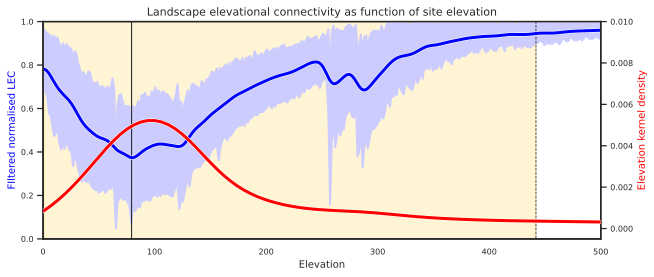

In [153]:
n, _ = np.histogram(df.Z, bins=2000)
sy, _ = np.histogram(df.Z, bins=2000, weights=df.LEC)
sy2, _ = np.histogram(df.Z, bins=2000, weights=df.LEC*df.LEC)
val = np.divide(sy, n, out=np.zeros_like(sy), where=n!=0) 
val2 = np.divide(sy2, n, out=np.zeros_like(sy2), where=n!=0) 
mean = val.copy()
std = np.sqrt(val2 - mean*mean)

xx = (_[1:] + _[:-1])/2


x1 = np.linspace(xx.min(), 500, num=1000, endpoint=True)
f = interp1d(xx, mean, kind='cubic')
yy = f(x1)

y_g = ndimage.gaussian_filter1d(yy, sigma=10)

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Landscape elevational connectivity as function of site elevation', fontsize=11)


plt.plot([zmean,zmean], [-1000,1000],'-',color='k',zorder=3,linewidth=1)
plt.plot([zmax,zmax], [-1000,1000],'--',color='k',zorder=3,linewidth=0.75)

iddd = np.where(x1<zmax)[0]
zones = np.ones(len(iddd))
yy = "#ffeaa8"
ax.fill_between(x1[iddd], zones-1000,zones+1000,color=yy,zorder=0,linewidth=2,alpha=0.5)
iddd2 = np.where(xx<zmax)[0]
print('LEC mean',np.mean(mean[iddd2]))

plt.plot(x1, y_g,color='white',zorder=4,linewidth=4)
plt.plot(x1, y_g,color='blue',zorder=4,linewidth=3)

ax.fill_between(xx, mean-std,mean+std,color='#ccccff',zorder=3,linewidth=2)


plt.ylim(0.0,1.0)
minZ = 0.0

ax.set_xlim(minZ,df.Z.max())
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

plt.xlabel('Elevation', fontsize=10)
plt.ylabel('FIltered normalised LEC', fontsize=10, color='blue')

ax2=ax.twinx()
df.Z.plot(kind='density',secondary_y=True, ax=ax2, xlim=(minZ,df.Z.max()),
               color='white', linewidth=4, zorder=5, fontsize = 8)
df.Z.plot(kind='density',secondary_y=True, ax=ax2, xlim=(minZ,df.Z.max()),
               color='red', linewidth=3, zorder=5, fontsize = 8)

plt.ylabel('Elevation kernel density', color='red', fontsize=10)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xlim(0,500)
plt.ylim(-0.0005,0.01)
plt.show()

plt.close()
fig.tight_layout()
# fig.savefig('lec'+str(step)+'.png',dpi=900)

In [154]:
flowmesh = 'vtk/Sarr700.corridor.bio.vtk'
 
mesh = meshio.read(flowmesh)

vertices = mesh.points
elev = mesh.point_data['Z']
flow = mesh.point_data['current']

In [155]:
cat = -np.ones(len(flow))
ids = np.where(np.logical_and(elev>0,elev<=50))[0]
cat[ids] = 1
ids = np.where(np.logical_and(elev>50,elev<=100))[0]
cat[ids] = 2
ids = np.where(np.logical_and(elev>100,elev<=150))[0]
cat[ids] = 3
ids = np.where(elev>150)[0]
cat[ids] = 4

In [156]:
df = pd.DataFrame(
    {
        "Z":  np.array(elev[shelfIDs].flatten()).byteswap().newbyteorder(),
        "cat": np.array(cat[shelfIDs].flatten()).byteswap().newbyteorder(),
        "flow": np.array(flow[shelfIDs].flatten()).byteswap().newbyteorder(),
    }
)

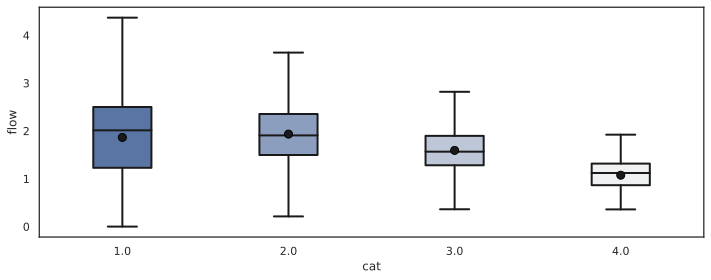

In [157]:
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(x="cat", y="flow", data=df, showfliers = False, width=0.35, ax=ax,showmeans=True,
            linewidth=2, 
            meanprops={"marker":"o",
                       "markerfacecolor":"k", 
                       "markeredgecolor":"black",
                      "markersize":"8"},palette="light:b_r")

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')

fig.tight_layout()
plt.show()

# plt.savefig('boxplot.png',dpi=900)
plt.close()

In [158]:
desc = df.groupby(['cat'])['flow'].describe()
Q1 = desc['25%'].values
Q3 = desc['75%'].values

mins = Q1-1.5*(Q3-Q1)
maxs = Q3+1.5*(Q3-Q1)

nobs = df['cat'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
print('Number of observations per category')
print(nobs)

medians = df.groupby(['cat'])['flow'].median().values
print('Median per category')
print(medians)

means = df.groupby(['cat'])['flow'].mean().values
print('Means per category')
print(means)

print('Whiskers min')
print(mins)

print('Whiskers max')
print(maxs)

Number of observations per category
['n: 35139', 'n: 13771', 'n: 7762', 'n: 111']
Median per category
[2.01285115 1.90672471 1.56686331 1.12077889]
Means per category
[1.86423555 1.93342171 1.59259285 1.07431045]
Whiskers min
[-0.67969354  0.2121844   0.35965199  0.18582707]
Whiskers max
[4.40911452 3.63819866 2.81907904 1.9958958 ]


In [159]:
fmax = flow.max()

In [160]:
n, _ = np.histogram(df.Z, bins=2000)
xx = (_[1:] + _[:-1])/2
flow_n = np.zeros(len(xx))
f_std = np.zeros(len(xx))
f_max = np.zeros(len(xx))
s_std = np.zeros(len(xx))
s_max = np.zeros(len(xx))
f_min = np.zeros(len(xx))
s_min = np.zeros(len(xx))
zz = df.Z.values
current = df.flow.values
for k in range(len(xx)):
    ids = np.where(np.logical_and(zz>=_[k],zz<_[k+1]))[0]
    if len(ids) > 0:
        flow_n[k] = np.mean(current[ids])
        f_std[k] = np.std(current[ids])
        f_max[k] = np.max(current[ids])
        f_min[k] = np.min(current[ids])
        
x1 = np.linspace(xx.min(), xx.max(), num=2000, endpoint=True)

f = interp1d(xx, flow_n, kind='cubic')
flow_smth = ndimage.gaussian_filter1d(f(x1), sigma=2)

f = interp1d(xx, f_std, kind='cubic')
flow_std = ndimage.gaussian_filter1d(f(x1), sigma=5)

f = interp1d(xx, f_max, kind='cubic')
flow_max = ndimage.gaussian_filter1d(f(x1), sigma=1)

f = interp1d(xx, f_min, kind='cubic')
flow_min = ndimage.gaussian_filter1d(f(x1), sigma=1)

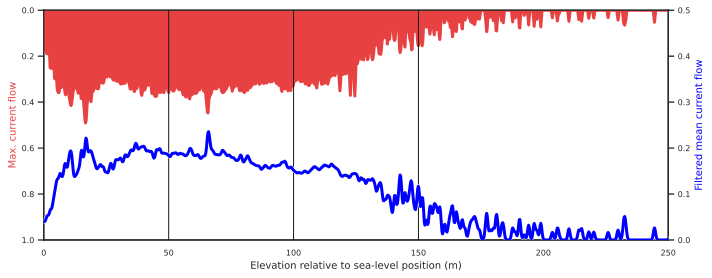

In [161]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(x1, flow_max/fmax,color='w',zorder=5,linewidth=4)
plt.plot(x1, flow_max/fmax,color='#e84141',zorder=5,linewidth=3)
ax.fill_between(xx, 0,flow_max/fmax,color='#e84141',zorder=6,linewidth=1)
plt.ylabel('Max. current flow', color='#e84141', fontsize=10)

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.xlabel('Elevation relative to sea-level position (m)', fontsize=10)
plt.xlim(0.,250)
plt.ylim(0,1.)
plt.gca().invert_yaxis()

ax2=ax.twinx()
ax2.plot(x1, flow_smth/fmax,color='w',zorder=5,linewidth=4)
ax2.plot(x1, flow_smth/fmax,color='blue',zorder=5,linewidth=3)
# plt.plot(x1, flow_max2,ls='--',color='blue',zorder=5,linewidth=1)
# plt.plot(x1, flow_min2,ls='--',color='blue',zorder=5,linewidth=1)

ax2.set_ylim(0,0.5)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8, color='k')
plt.ylabel('Filtered mean current flow', fontsize=10, color='blue')


plt.plot([50,50], [0,1000],'-',color='k',zorder=3,linewidth=1)
plt.plot([100,100], [0,1000],'-',color='k',zorder=3,linewidth=1)
plt.plot([150,150], [0,1000],'-',color='k',zorder=3,linewidth=1)


fig.tight_layout()
plt.show()

# plt.savefig('shelfcurrent.png',dpi=900)
plt.close()